In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


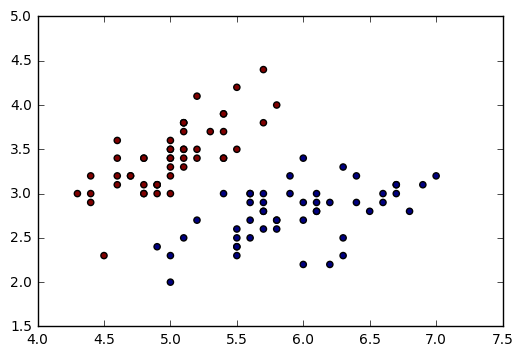

In [3]:
def get_iris():
    data = pd.read_csv("../data/iris/iris.data", header=None)
    
    data_filtered = data[data[4].isin(['Iris-setosa', 'Iris-versicolor'])]
    data_filtered[4] = data_filtered[4].apply(lambda x: 1 if x == 'Iris-setosa' else -1)
    
    data_array = data_filtered.values
    X = data_array[:, :2]
    y = data_array[:, 4]
    
    return X, y

X_iris, y_iris = get_iris()
plt.scatter(X_iris[:,0], X_iris[:,1], c=y_iris)

In [4]:
data = pd.read_csv("../data/housing/housing.data", header=None)
data = data[[2, 3, 4, 7, 8, 9, 11]]
X_housing = data.values
y_housing = data.apply(lambda x: 2*(x[2] + x[3] <= -85.5)-1, axis=1)
y_housing.sum()/len(y_housing)

-0.21240310077519381

In [5]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_housing_fit = scaler.fit_transform(X_housing)

In [6]:
def polygon(n_samples=100, add_noise=0, verbose=True):
    # data
    ths = np.linspace(0, 2*np.pi*(1-1.0/n_samples), n_samples)
    ths += np.random.normal(0,0.1)
    data = np.array([np.cos(ths), np.sin(ths)]).T
    
    if add_noise > 0:
        data = np.hstack([data, np.random.uniform(size=(len(data), add_noise))])
        
    # labels
    labels = 2*(data[:,0] > 0) - 1
    
    return data, labels

X_pol, y_pol = polygon(200)

In [7]:
# MUSHROOM dataset
data = pd.read_csv('../data/mushroom/mushroom.data')
y = data['p'].map(lambda x: 1 if x == 'e' else -1)
X = data.drop(['p', 'e.1', 'p.2'], axis=1)

# get H matrix
X_mush = pd.get_dummies(X).applymap(lambda x: 2*x-1).values
y_mush = y.values

In [8]:
# DERMATOLOGY dataset
data = pd.read_csv('../data/dermatology/dermatology.data').applymap(lambda x: str(x))
X = data.drop('2.3', axis=1)
y = data['2.3']

mask = y.isin(['1','2','3'])
X = X[mask].reset_index(drop=True)
y = y[mask].reset_index(drop=True).apply(lambda x: -1 if x == '2' else 1)

X_derm = (2.0*pd.get_dummies(X) - 1).values
y_derm = y.values

In [9]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
clf = SVC(C=10000, kernel='linear', max_iter=100000)
clf.fit(X_housing_fit,y_housing)
accuracy_score(clf.predict(X_housing_fit), y_housing)

/usr/local/lib/python3.5/dist-packages/sklearn/svm/base.py:220: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


1.0

In [18]:
from src.user import DummyUser
from src.utils import Adaboost
from src.active_learning.boosting import QueryByBoosting, ActBoost
from src.active_learning.svm import SVMClosest, SolverMethod
from src.active_learning.agnostic import RandomLearner
from src.active_learning.base import train
from src.initial_sampling import FixedSizeStratifiedSampler
from src.showdown import compare_learners

times = 5
max_iter = 50
user_housing = DummyUser(max_iter=max_iter, y_true=y_housing)
user_iris = DummyUser(max_iter=max_iter, y_true=y_iris)
user_pol = DummyUser(max_iter=max_iter, y_true=y_pol)
user_mush = DummyUser(y_true=y_mush, max_iter=max_iter)
user_derm = DummyUser(y_true=y_derm, max_iter=max_iter)

initial_sampler = FixedSizeStratifiedSampler(sample_size=10)

active_learners = [
     #("random", initial_sampler, RandomLearner(SVC(C=1000, kernel='linear'))),
     #("linearSVM", initial_sampler, SVMClosest(C=1000, kernel='linear')),
     #("rbfSVM", initial_sampler, SVMClosest(C=100, kernel='rbf')),
     #("solver5", initial_sampler, SolverMethod(pool_size=5, C=1000, kernel='linear')),
     #("solver10", initial_sampler, SolverMethod(pool_size=10, C=1000, kernel='linear')),
     #("solver20", initial_sampler, SolverMethod(pool_size=20, C=1000, kernel='linear'))
     ("actboost", initial_sampler, ActBoost(chain_length=50, sample_size=8, n_iterations=300)),
     ("random", initial_sampler, RandomLearner(Adaboost(n_iterations=300))),
     ("qbb", initial_sampler, QueryByBoosting(n_iterations=300)), 
]

datasets = [
    #("housing", X_housing_fit, user_housing),
    #("iris", X_iris, user_iris),
    #("polygon1", X_pol, user_pol),
    ("mushroom", X_mush, user_mush),
    ("dermatology", X_derm, user_derm)
]

output = compare_learners(active_learners, times, datasets)
output.head()

mushroom                                                              \
          f1                                                               
    actboost                                  random                       
        mean       std       min       max      mean       std       min   
11  0.805000  0.123167  0.625043  0.909276  0.851736  0.080112  0.709297   
12  0.762340  0.188155  0.475430  0.909276  0.859600  0.093741  0.693546   
13  0.736741  0.238833  0.347432  0.909276  0.854701  0.097043  0.682874   
14  0.748997  0.230668  0.347432  0.881075  0.863257  0.061459  0.761072   
15  0.729459  0.233883  0.347432  0.881075  0.880343  0.068783  0.761072   

                                    ...    dermatology                      \
                                    ...       accuracy                       
                   qbb              ...       actboost              random   
         max      mean       std    ...            min       max      mean   
11  0.902370  0.788928  0.120393    ...       0.581967  0.831967  0.750000   
12  0.917666  0.779994  0.158314    ...       0.581967  0.831967  0.765574   
13  0.917666  0.781010  0.121740    ...       0.581967  0.922131  0.767213   
14  0.917666  0.863852  0.041965    ...       0.655738  0.918033  0.753279   
15  0.922787  0.798200  0.086766    ...       0.655738  0.918033  0.759016   

                                                                          
                                                                          
                                       qbb                                
         std       min       max      mean       std       min       max  
11  0.059462  0.704918  0.831967  0.592623  0.153445  0.450820  0.827869  
12  0.069576  0.680328  0.831967  0.611475  0.144388  0.475410  0.840164  
13  0.077241  0.635246  0.823770  0.648361  0.153768  0.491803  0.823770  
14  0.076201  0.635246  0.827869  0.675410  0.146811  0.487705  0.823770  
15  0.056447  0.696721  0.831967  0.708197  0.129420  0.516393  0.823770  

[5 rows x 48 columns]

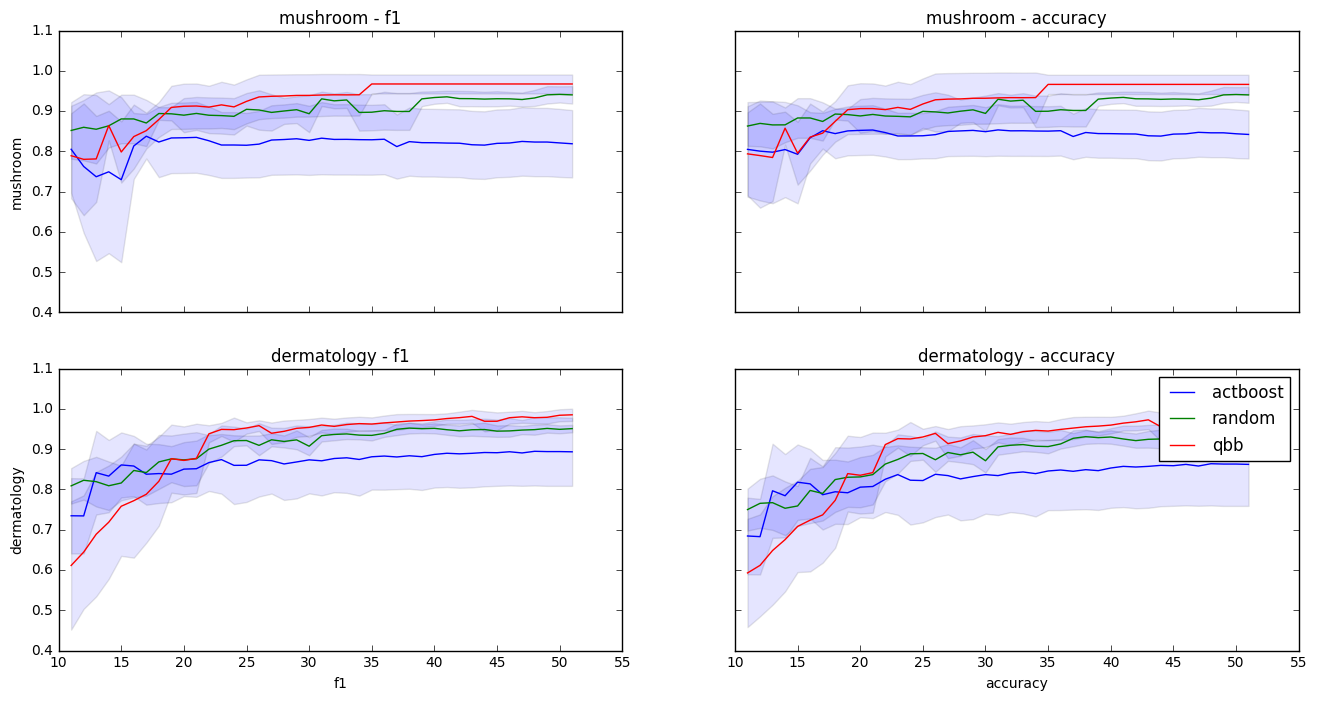

In [19]:
def plot_output(output):
    data_tags = output.columns.levels[0]
    metric_list = output.columns.levels[1]
    als = output.columns.levels[2]

    fig, axs = plt.subplots(len(data_tags), len(metric_list), sharex=True, sharey=True)
    if len(data_tags) == 1:
        axs = [axs]

    width=8
    fig.set_size_inches(2*width,width)

    for i, ds in enumerate(data_tags):
        for j, name in enumerate(metric_list):
            ax = axs[i][j]
            ax.set_title(ds+" - "+name)
            if i == len(data_tags) - 1:
                ax.set_xlabel(name)
            if j == 0:
                ax.set_ylabel(ds)

            for al in als:
                df = output[ds][name][al]
                x = df.index
                y = df['mean']
                error = 1.96*df['std']/np.sqrt(times)
                ax.plot(x, y, label=al)

                ax.fill_between(x, y-error, y+error, alpha=0.1)#, edgecolor='#CC4F1B', facecolor='#FF9848')

    plt.legend()
    #plt.savefig('test.png')
    plt.show()
    
plot_output(output)